In [1]:
import json
import numpy as np
import os

In [2]:
texts = []
labels = []
#실행 파일과 같은 폴더에 파일들이 존재해야 합니다.
for i in range(1, 500):
    file_name = f'기술_과학_{i}.json'  
    
    if os.path.exists(file_name):  # 파일이 존재하는 경우에만 처리
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        for conversation in data["dataset"].get("conversations", []):
            for utterance in conversation.get("utterances", []):
                text = utterance.get("utterance_text", "")
                evaluation = utterance.get("utterance_evaluation", [])
                if evaluation:  # 평가 대상이 아닌 문장을 제외
                    texts.append(text)
                    labels.append(evaluation)

In [3]:
#토큰화 코드: 라이브러리 사용
import konlpy 
from konlpy.tag import Okt, Hannanum, Kkma 

okt = Okt()
tokenized_texts = []

for i in range(len(texts)):
    tokenized_texts.append(okt.morphs(texts[i]))

In [4]:
#word2vec 과정
_word_to_id = {}
_id_to_word = {}

def preprocess(words): #앞에서 토큰화를 해서 적절히 바꿨습니다. 
    for word in words:
        if word not in _word_to_id:
            new_id = len(_word_to_id)
            _word_to_id[word] = new_id
            _id_to_word[new_id] = word
    corpus = np.array([_word_to_id[w] for w in words])
    return corpus, _word_to_id, _id_to_word

In [5]:
attribute_labels = {
    'linguistic_acceptability': [],
    'consistency': [],
    'interestingness': [],
    'unbias': [],
    'harmlessness': [],
    'no_hallucination': [],
    'understandability': [],
    'sensibleness': [],
    'specificity': []
}

# 속성별 레이블 추출
for i in range(len(labels)):
    # 현재 대화에 대한 속성값 초기화
    attribute_values = {key: 0 for key in attribute_labels.keys()}

    for j in range(len(labels[i])):
        for key in attribute_labels.keys():
            if labels[i][j].get(key) == 'yes':
                attribute_values[key] += 1

    # 각 속성별로 모든 발화에서 'yes'인 경우만 1, 아니면 0
    for key in attribute_labels.keys():
        if attribute_values[key] == len(labels[i]):
            attribute_labels[key].append(1)
        else:
            attribute_labels[key].append(0)

In [6]:
# %load cbow.py
import sys
sys.path.append('..')
from common.np import *  # import numpy as np
from common.layers import Embedding
from negative_sampling_layer import NegativeSamplingLoss


class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')

        # 계층 생성
        self.in_layers = []
        for i in range(2 * window_size):
            layer = Embedding(W_in)  # Embedding 계층 사용
            self.in_layers.append(layer)
        self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 모든 가중치와 기울기를 배열에 모은다.
        layers = self.in_layers + [self.ns_loss]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i])
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout *= 1 / len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

In [7]:
from common.optimizer import Adam
from common.trainer import Trainer
from common.util import create_contexts_target, to_cpu, to_gpu

window_size = 2
hidden_size = 100
batch_size = 100
max_epoch = 10

flattened_texts = [item for sublist in tokenized_texts for item in sublist]

corpus, word_to_id, id_to_word = preprocess(flattened_texts)  
vocab_size = len(word_to_id)

model = CBOW(vocab_size, hidden_size, window_size, corpus)
# model = SkipGram(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

In [8]:
contexts, target = create_contexts_target(corpus, window_size)
trainer.fit(contexts, target, max_epoch, batch_size)

| 에폭 1 |  반복 1 / 1322 | 시간 0[s] | 손실 4.16
| 에폭 1 |  반복 21 / 1322 | 시간 1[s] | 손실 4.16
| 에폭 1 |  반복 41 / 1322 | 시간 2[s] | 손실 4.16
| 에폭 1 |  반복 61 / 1322 | 시간 3[s] | 손실 4.15
| 에폭 1 |  반복 81 / 1322 | 시간 3[s] | 손실 4.13
| 에폭 1 |  반복 101 / 1322 | 시간 4[s] | 손실 4.08
| 에폭 1 |  반복 121 / 1322 | 시간 5[s] | 손실 3.99
| 에폭 1 |  반복 141 / 1322 | 시간 6[s] | 손실 3.88
| 에폭 1 |  반복 161 / 1322 | 시간 7[s] | 손실 3.76
| 에폭 1 |  반복 181 / 1322 | 시간 8[s] | 손실 3.65
| 에폭 1 |  반복 201 / 1322 | 시간 9[s] | 손실 3.52
| 에폭 1 |  반복 221 / 1322 | 시간 10[s] | 손실 3.44
| 에폭 1 |  반복 241 / 1322 | 시간 11[s] | 손실 3.36
| 에폭 1 |  반복 261 / 1322 | 시간 12[s] | 손실 3.27
| 에폭 1 |  반복 281 / 1322 | 시간 13[s] | 손실 3.22
| 에폭 1 |  반복 301 / 1322 | 시간 14[s] | 손실 3.16
| 에폭 1 |  반복 321 / 1322 | 시간 15[s] | 손실 3.09
| 에폭 1 |  반복 341 / 1322 | 시간 16[s] | 손실 3.06
| 에폭 1 |  반복 361 / 1322 | 시간 17[s] | 손실 3.02
| 에폭 1 |  반복 381 / 1322 | 시간 18[s] | 손실 3.00
| 에폭 1 |  반복 401 / 1322 | 시간 19[s] | 손실 2.98
| 에폭 1 |  반복 421 / 1322 | 시간 20[s] | 손실 2.95
| 에폭 1 |  반복 441 / 1322 | 시

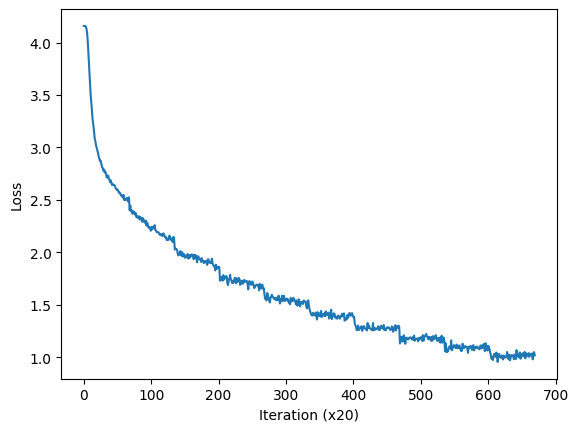

In [9]:
trainer.plot()

In [10]:
from common.util import most_similar, analogy
querys = ['.', '인공', '지능', '코로나','백신']
for query in querys:
    most_similar(query, word_to_id, id_to_word, model.word_vecs, top=5)


[query] .
 !: 0.8231019377708435
 7,500년: 0.7168320417404175
 구래: 0.6689790487289429
 라운드테이블: 0.6616462469100952
 작곡가: 0.6472958326339722

[query] 인공
 초인: 0.7396249771118164
 대리: 0.7002465128898621
 플릿: 0.694988489151001
 뛰어넘어: 0.6734489798545837
 ASI: 0.6523380875587463

[query] 지능
 혈액: 0.8071379065513611
 신경망: 0.7381097674369812
 골기질: 0.7052156925201416
 체제: 0.6890137195587158
 부본: 0.6735222935676575

[query] 코로나
 19: 0.8727309107780457
 팬데믹: 0.767221987247467
 QTP: 0.7537067532539368
 GLS: 0.7406914234161377
 백신: 0.7359030246734619

[query] 백신
 19: 0.7873284220695496
 영상: 0.753519594669342
 팬데믹: 0.7403199076652527
 코로나: 0.7359030246734619
 수식: 0.7245535254478455


In [11]:
contexts, target = create_contexts_target(corpus, window_size)
loss = model.forward(contexts, target)
print("Loss:", loss)

Loss: 0.9337649


In [12]:
for i in range(500, 550):
    file_name = f'기술_과학_{i}.json'  
    
    if os.path.exists(file_name):  # 파일이 존재하는 경우에만 처리
        with open(file_name, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        for conversation in data["dataset"].get("conversations", []):
            for utterance in conversation.get("utterances", []):
                text = utterance.get("utterance_text", "")
                evaluation = utterance.get("utterance_evaluation", [])
                if evaluation:  # 평가 대상이 아닌 문장을 제외
                    texts.append(text)
                    labels.append(evaluation)

In [13]:
attribute_labels = {
    'linguistic_acceptability': [],
    'consistency': [],
    'interestingness': [],
    'unbias': [],
    'harmlessness': [],
    'no_hallucination': [],
    'understandability': [],
    'sensibleness': [],
    'specificity': []
}

# 속성별 레이블 추출
for i in range(len(labels)):
    # 현재 대화에 대한 속성값 초기화
    attribute_values = {key: 0 for key in attribute_labels.keys()}

    for j in range(len(labels[i])):
        for key in attribute_labels.keys():
            if labels[i][j].get(key) == 'yes':
                attribute_values[key] += 1

    # 각 속성별로 모든 발화에서 'yes'인 경우만 1, 아니면 0
    for key in attribute_labels.keys():
        if attribute_values[key] == len(labels[i]):
            attribute_labels[key].append(1)
        else:
            attribute_labels[key].append(0)

In [14]:
tokenized_texts = []

losses = []

for i in range(len(texts)):
    tokenized_texts.append(okt.morphs(texts[i]))

for i in range(len(tokenized_texts)):
    try:
        corpus, word_to_id, id_to_word = preprocess(tokenized_texts[i]) 
        contexts, target = create_contexts_target(corpus, window_size)
        loss = model.forward(contexts, target)
        losses.append(loss)
    except:
        losses.append(-1)


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

losses = np.array(losses).reshape(-1, 1)

for key in attribute_labels.keys():
    try: 
        X_train, X_test, y_train, y_test = train_test_split(losses, attribute_labels[key], test_size=0.3, random_state=42)
        model2 = LogisticRegression()
        model2.fit(X_train, y_train)
        y_pred  = model2.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(key, accuracy)
    except:
        print(key, '에서 에러가 발생') #값이 모두 yes인 경우

linguistic_acceptability 0.8463455149501661
consistency 0.9966777408637874
interestingness 0.8845514950166113
unbias 0.8596345514950167
harmlessness 0.8488372093023255
no_hallucination 0.9111295681063123
understandability 0.659468438538206
sensibleness 0.9759136212624585
specificity 0.8903654485049833
